# Cognitive Age Prediction with MRI and MEG

In [1]:
import dill
import pandas as pd
import mne
import numpy as np

from camcan.utils import (run_stacking, run_ridge, plot_pred, plot_learning_curve, plot_boxplot,
                          plot_barchart, plot_error_scatters, plot_error_age, plot_error_segments)

%matplotlib inline

/home/okozynet/projects/scikit-learn/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/okozynet/miniconda3/envs/mne/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/okozynet/miniconda3/envs/mne/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/okozynet/miniconda3/envs/mne/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate bin

In [2]:
CV = 10
N_JOBS = -1
# store mae, std for the summary plot
anatomy_mae = {}
function_mae = {}
meg_mae = {}
multimodal_mae = {}

anatomy_mae_std = {}
function_mae_std = {}
meg_mae_std = {}
multimodal_mae_std = {}

## Structural MRI

### Read Data

In [3]:
# read information about subjects
subjects_data = pd.read_csv('../../data/participant_data.csv', index_col=0)
# for storing predictors data
subjects_predictions = pd.DataFrame(subjects_data.age, index=subjects_data.index, dtype=float)

subjects_data.head()

,age,hand,gender_text,gender_code,tiv_cubicmm,cbuid700,cbuid280_sess1,cbuid280_sess2,cbuid280_sess3,cbuid280_sess4,profilecode,profilecode_numeric
Observations,,,,,,,,,,,,
CC110033,24,90.0,MALE,1,1413746.0,CBU120746,NaN,NaN,NaN,NaN,NaN,NaN
CC110037,18,89.0,MALE,1,1386581.0,CBU110544,NaN,NaN,NaN,NaN,NaN,NaN
CC110045,24,100.0,FEMALE,2,1385355.0,CBU111116,NaN,NaN,NaN,NaN,NaN,NaN
CC110056,22,100.0,FEMALE,2,1286849.0,CBU110547,NaN,CBU140153,CBU140224,NaN,D,1.0
CC110062,20,58.0,MALE,1,1582719.0,CBU110468,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# read features

area_data = pd.read_hdf('../../data/structural/structural_data.h5', 
                           key='area')
thickness_data = pd.read_hdf('../../data/structural/structural_data.h5',
                               key='thickness')
volume_data = pd.read_hdf('../../data/structural/structural_data.h5',
                            key='volume')

volume_data.head()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol
Measure:volume,,,,,,,,,,,,,,,,,,,,,
CC110037,5150.4,226.8,14923.5,59652.3,7732.1,3223.5,4647.4,2154.4,773.3,1478.8,...,1.032711e+06,1.022294e+06,1019858.0,1618468.0,0.782415,1.072228,19.0,30.0,49.0,1.509444e+06
CC110045,3979.6,114.6,15619.4,60867.2,7913.9,4010.3,5193.4,2167.9,744.9,1478.4,...,1.014279e+06,1.005687e+06,1003304.0,1598634.0,0.743644,1.018101,33.0,21.0,54.0,1.570212e+06
CC110174,3030.9,154.3,11359.7,47716.3,6950.6,3036.8,4359.9,1804.4,627.6,2053.0,...,8.302810e+05,8.241440e+05,822083.0,1288111.0,0.782147,1.056538,21.0,22.0,43.0,1.219181e+06
CC110087,12787.4,443.5,13064.4,52932.6,7044.1,3082.6,4549.0,2015.4,1141.6,1608.2,...,9.426949e+05,9.215889e+05,919271.0,1506891.0,0.759388,1.062592,38.0,38.0,76.0,1.418128e+06
CC110182,12419.5,302.9,15901.4,51487.2,7644.4,3638.7,4780.9,2092.5,948.8,1617.4,...,9.641663e+05,9.382583e+05,935647.0,1510723.0,0.741729,1.017294,27.0,34.0,61.0,1.485041e+06


In [5]:
area_data = area_data.dropna()
thickness_data = thickness_data.dropna()
volume_data = volume_data.dropna()

### Training and Prediction

#### Area

MAE: 12.15
MAE STD: 4.86


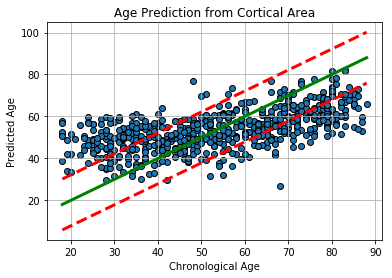

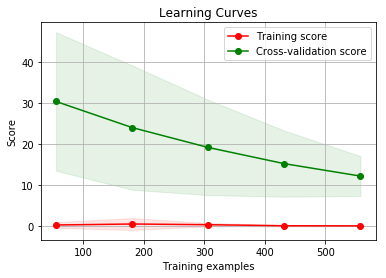

In [6]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores = \
    run_ridge(area_data, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae['Cortical Surface Area'] = arr_mae
anatomy_mae_std['Cortical Surface Area'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'Cortical Surface Area'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Cortical Surface Area'],
          mae, title='Age Prediction from Cortical Area')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Thickness

MAE: 7.96
MAE STD: 2.29


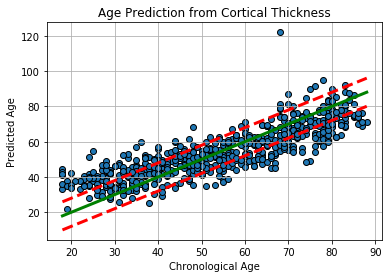

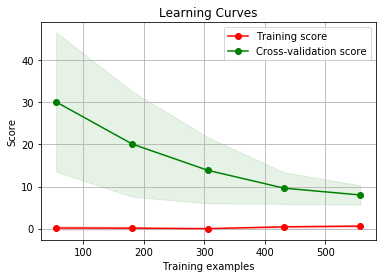

In [7]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(thickness_data, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae['Cortical Thickness'] = arr_mae
anatomy_mae_std['Cortical Thickness'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'Cortical Thickness'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Cortical Thickness'],
          mae, title='Age Prediction from Cortical Thickness')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Volume

MAE: 7.39
MAE STD: 1.85


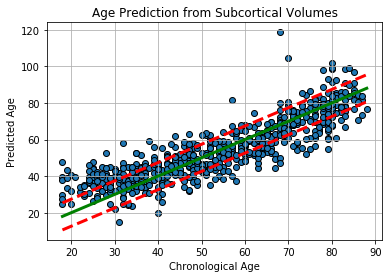

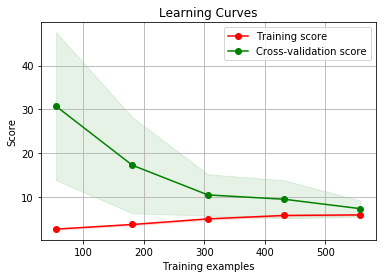

In [8]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(volume_data, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae['Subcortical Volumes'] = arr_mae
anatomy_mae_std['Subcortical Volumes'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'Subcortical Volumes'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Subcortical Volumes'],
          mae, title='Age Prediction from Subcortical Volumes')
plot_learning_curve(train_sizes, train_scores, test_scores)

## Functional MRI

### BASC 197

In [9]:
# read connectivity data
connect_data_tangent_basc = pd.read_hdf('../../data/connectivity/connect_data_tangent.h5',
                              key='basc197')
connect_data_r2z_basc = pd.read_hdf('../../data/connectivity/connect_data_correlation.h5',
                              key='basc197')
connect_data_tangent_basc.head()

,0,1,2,3,4,5,6,7,8,9,...,19493,19494,19495,19496,19497,19498,19499,19500,19501,19502
CC110033,0.096697,-0.140008,0.067199,-0.013200,0.040234,-0.163020,-0.029214,0.156358,0.078821,0.087680,...,-0.037457,0.044814,0.021185,-0.036576,-0.054100,-0.002762,0.053630,0.022528,-0.006503,0.273724
CC110037,-0.591520,-0.088332,-0.723872,0.101235,-0.012502,-0.854274,0.029541,0.023450,-0.067513,-1.492769,...,-0.067943,-0.124460,-0.034104,-0.103519,0.098355,-0.021281,0.136260,-0.073003,0.048019,-0.070249
CC110045,-0.042581,-0.176352,-0.037048,0.141138,-0.055788,-0.007159,0.041272,0.144073,-0.075119,0.061303,...,0.037748,-0.021896,0.097779,0.053294,0.060940,-0.000433,-0.062330,-0.039093,0.033913,-0.148330
CC110069,-0.442311,-0.079525,-0.141859,0.023382,-0.061421,-0.358688,0.069646,-0.011345,0.072415,0.156324,...,0.035603,-0.036768,-0.023163,0.023483,-0.037131,-0.039623,-0.011263,0.056086,-0.144799,-0.178823
CC110087,-0.097007,-0.133572,0.074754,0.099027,-0.034863,-0.310058,0.031366,-0.022870,0.071330,-0.108389,...,-0.073019,-0.152082,0.123719,-0.041476,0.067740,0.094479,0.045866,0.040174,-0.045647,0.129202


#### Tangent Space

MAE: 6.89
MAE STD: 2.94


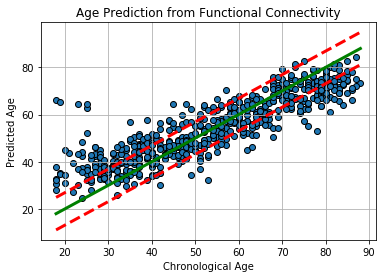

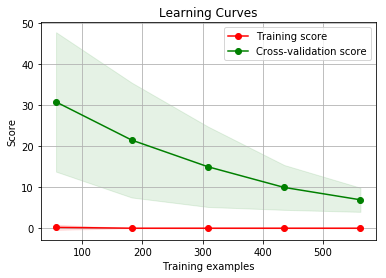

In [10]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(connect_data_tangent_basc, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Connectivity Matrix, BASC 197 tan'] = (mae, std)
function_mae['Connectivity Matrix, BASC 197 tan'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, BASC 197 tan'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, BASC 197 tan'],
          mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Connectivity with Fisher's r-to-z Transform

MAE: 7.16
MAE STD: 1.85


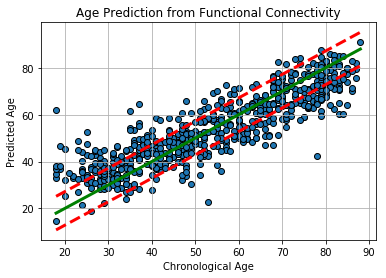

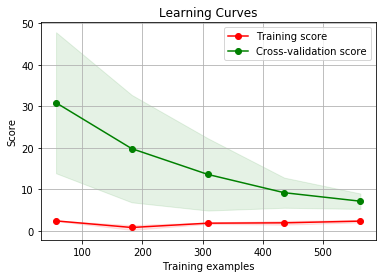

In [11]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(connect_data_r2z_basc, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Connectivity Matrix, BASC 197 r2z'] = (mae, std)
function_mae['Connectivity Matrix, BASC 197 r2z'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, BASC 197 r2z'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, BASC 197 r2z'],
          mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

### MODL 256

In [12]:
# read connectivity data
connect_data_tangent_modl = pd.read_hdf('../../data/connectivity/connect_data_tangent.h5',
                              key='modl256')
connect_data_r2z_modl = pd.read_hdf('../../data/connectivity/connect_data_correlation.h5',
                              key='modl256')
connect_data_tangent_modl.head()

,0,1,2,3,4,5,6,7,8,9,...,32886,32887,32888,32889,32890,32891,32892,32893,32894,32895
CC110033,0.074408,-0.018078,-0.026110,-0.035737,0.026987,-0.148206,-0.123741,0.043818,-0.007511,0.028245,...,0.033294,0.047502,0.026974,-0.018982,0.119100,0.139546,-0.001772,0.049109,0.009093,-0.208286
CC110037,-1.691638,-0.026637,-0.530353,0.047946,-0.010420,-1.973813,-0.068899,-0.057347,-0.048387,0.615105,...,-0.008444,-0.012884,0.050008,0.042905,0.058089,-0.024558,0.064888,-0.070759,0.024871,-1.646669
CC110045,0.129928,0.083970,-0.255726,-0.051040,0.090631,-0.166786,0.005209,0.121638,-0.003998,-0.167915,...,-0.010775,-0.043265,0.014613,-0.004538,-0.020235,0.050549,0.285926,-0.061542,0.206019,0.149908
CC110069,-0.155261,-0.004314,-0.298256,-0.103225,0.001456,-0.616323,-0.002113,0.057129,-0.043140,0.176846,...,-0.032800,0.072003,-0.247339,0.149980,-0.059462,-0.071107,-0.107166,0.025952,-0.043589,0.311891
CC110087,-0.304658,-0.012165,-0.093857,0.011350,0.101019,-0.086796,-0.099032,-0.083703,-0.038678,0.065644,...,0.035628,-0.133997,0.058017,-0.014234,-0.035109,-0.067293,-0.054121,-0.024550,-0.095122,-0.023328


#### Tangent Space

MAE: 6.85
MAE STD: 3.07


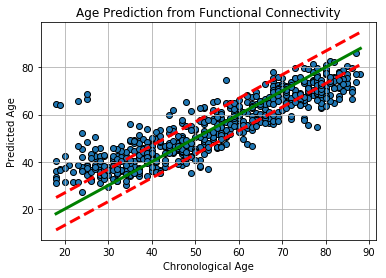

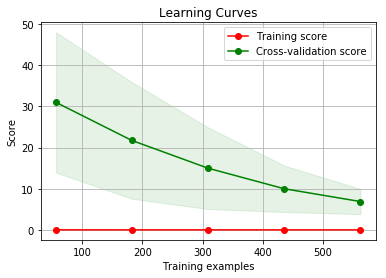

In [13]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(connect_data_tangent_modl, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Connectivity Matrix, MODL 256 tan'] = (mae, std)
function_mae['Connectivity Matrix, MODL 256 tan'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, MODL 256 tan'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, MODL 256 tan'],
          mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Connectivity with Fisher's r-to-z Transform

MAE: 6.49
MAE STD: 1.94


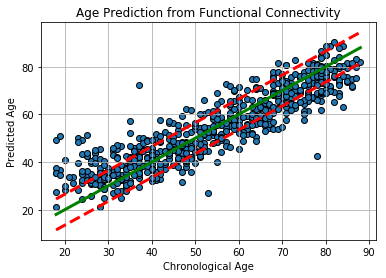

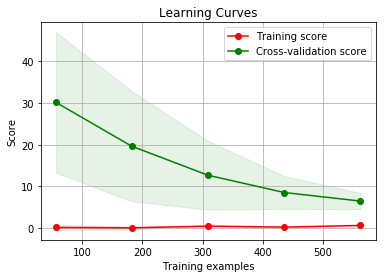

In [14]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_ridge(connect_data_r2z_modl, subjects_data, cv=CV, n_jobs=N_JOBS)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Connectivity Matrix, MODL 256 r2z'] = (mae, std)
function_mae['Connectivity Matrix, MODL 256 r2z'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, MODL 256 r2z'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Connectivity Matrix, MODL 256 r2z'],
          mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

## MEG

In [15]:
FREQ_BANDS = ('alpha',
              'beta_high',
              'beta_low',
              'delta',
              'gamma_high',
              'gamma_lo',
              'gamma_mid',
              'low',
              'theta')

In [16]:
MEG_SOURCE_SPACE_DATA = '../../data/meg_source_space_data.h5'

meg_data = pd.read_hdf(MEG_SOURCE_SPACE_DATA, key='meg')

columns_to_exclude = ('band', 'fmax', 'fmin', 'subject')
parcellation_labels = [c for c in meg_data.columns if c
                       not in columns_to_exclude]
band_data = [meg_data[meg_data.band == bb].set_index('subject')[
                parcellation_labels] for bb in FREQ_BANDS]
meg_data = pd.concat(band_data, axis=1, join='inner', sort=False)

print(f'Found {len(meg_data)} subjects')

Found 595 subjects


MAE: 8.22
MAE STD: 2.31


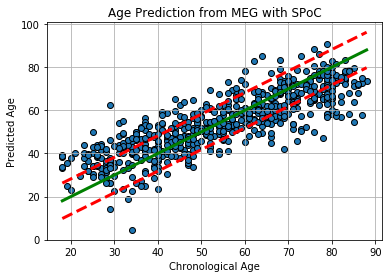

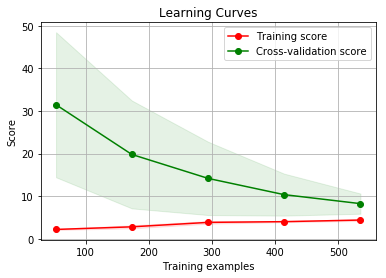

In [17]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores = \
    run_ridge(meg_data, subjects_data, cv=CV)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

meg_mae['MEG'] = arr_mae
meg_mae_std['MEG'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'MEG'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'MEG'],
          mae, title='Age Prediction from MEG with SPoC')
plot_learning_curve(train_sizes, train_scores, test_scores)

## Stacking

Parameters for stacking were taken from [Liem's paper](https://github.com/fliem/LeiCA_LIFE/blob/e9d02464a9e43b97cef9c7b753d88120cfbd6c94/learning/learning_stacking_utils.py#L30)

### Anatomy

MAE: 7.38
MAE STD: 1.77


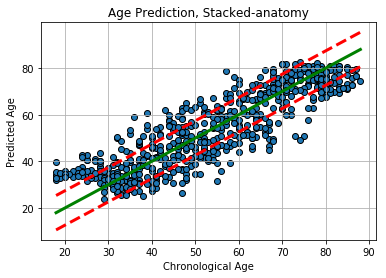

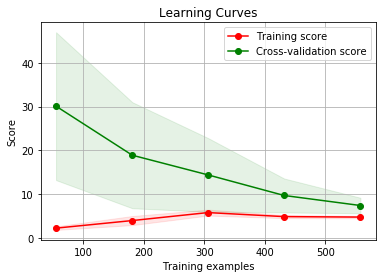

In [18]:
anatomy_data = [('area', area_data), ('thickness', thickness_data), ('volume', volume_data)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(anatomy_data, subjects_data, cv=CV)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

anatomy_mae_std['Stacked-anatomy'] = (mae, std)
anatomy_mae['Stacked-anatomy'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Stacked-anatomy'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Stacked-anatomy'],
          mae, title='Age Prediction, Stacked-anatomy')
plot_learning_curve(train_sizes, train_scores, test_scores)

### Connectivity

MAE: 7.67
MAE STD: 2.66


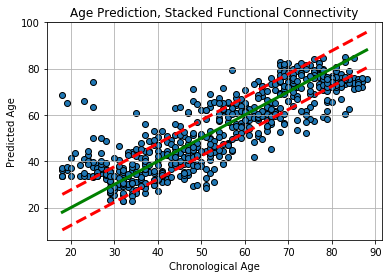

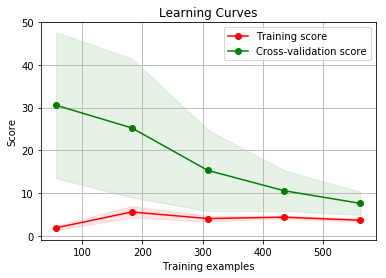

In [19]:
connect_data_tanh = [('basc', connect_data_tangent_basc), ('modl', connect_data_tangent_modl)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(connect_data_tanh, subjects_data, cv=CV)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

function_mae_std['Stacked-function'] = (mae, std)
function_mae['Stacked-function'] = arr_mae
subjects_predictions.loc[df_pred.index, 'Stacked-function'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'Stacked-function'],
          mae, title='Age Prediction, Stacked Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

### MRI Multi-modal 

MAE: 6.49
MAE STD: 2.53


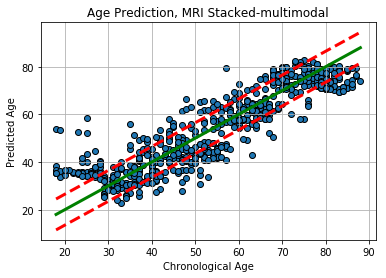

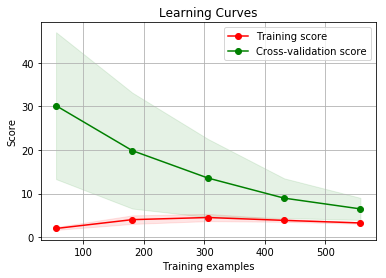

In [20]:
multimodal_data = [('area', area_data), ('thickness', thickness_data), ('volume', volume_data),
                   ('basc', connect_data_tangent_basc), ('modl', connect_data_tangent_modl)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(multimodal_data, subjects_data, cv=CV)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

multimodal_mae_std['MRI Stacked-multimodal'] = (mae, std)
multimodal_mae['MRI Stacked-multimodal'] = arr_mae
subjects_predictions.loc[df_pred.index, 'MRI Stacked-multimodal'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'MRI Stacked-multimodal'],
          mae, title='Age Prediction, MRI Stacked-multimodal')
plot_learning_curve(train_sizes, train_scores, test_scores)

### MEG with MRI Multi-modal

MAE: 6.43
MAE STD: 1.72


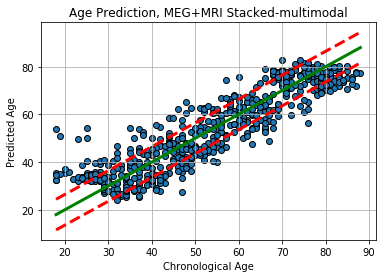

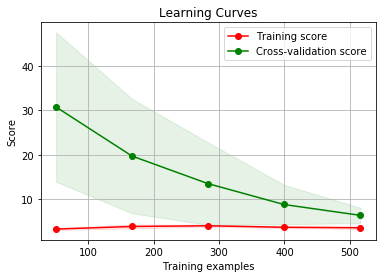

In [21]:
multimodal_data = [('area', area_data), ('thickness', thickness_data), ('volume', volume_data),
                   ('basc', connect_data_tangent_basc), ('meg', meg_data)]

df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores \
    = run_stacking(multimodal_data, subjects_data, cv=CV)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

multimodal_mae_std['MEG+MRI Stacked-multimodal'] = (mae, std)
multimodal_mae['MEG+MRI Stacked-multimodal'] = arr_mae
subjects_predictions.loc[df_pred.index, 'MEG+MRI Stacked-multimodal'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'MEG+MRI Stacked-multimodal'],
          mae, title='Age Prediction, MEG+MRI Stacked-multimodal')
plot_learning_curve(train_sizes, train_scores, test_scores)

## Summary

### Results from Liem2016

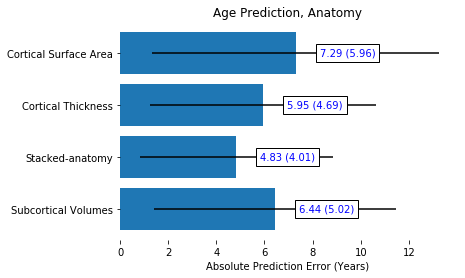

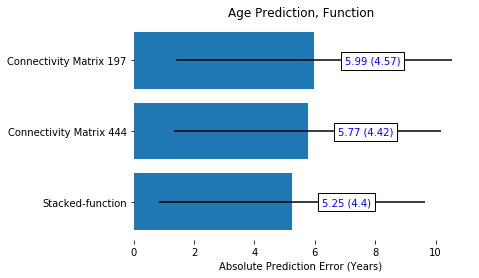

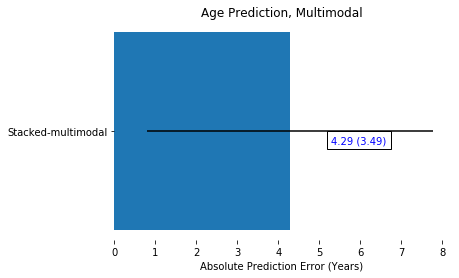

In [22]:
anatomy_mae_std_liem = {'Cortical Thickness': (5.95, 4.69),
                        'Cortical Surface Area': (7.29, 5.96),
                        'Subcortical Volumes': (6.44, 5.02),
                        'Stacked-anatomy': (4.83, 4.01)}

connect_mae_std_liem = {'Connectivity Matrix 197': (5.99, 4.57),
                        'Connectivity Matrix 444': (5.77, 4.42),
                        'Stacked-function': (5.25, 4.4)}

multimodal_mae_std_liem = {'Stacked-multimodal': (4.29, 3.49)}

plot_barchart(anatomy_mae_std_liem, title='Age Prediction, Anatomy', bar_text_indent=1)
plot_barchart(connect_mae_std_liem, title='Age Prediction, Function', bar_text_indent=1)
plot_barchart(multimodal_mae_std_liem, title='Age Prediction, Multimodal', bar_text_indent=1)

### Results for CamCAN

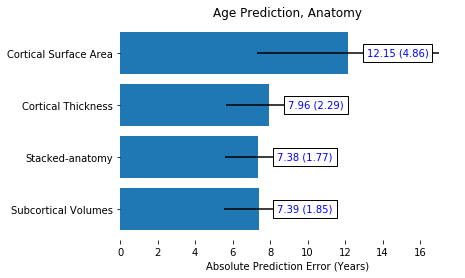

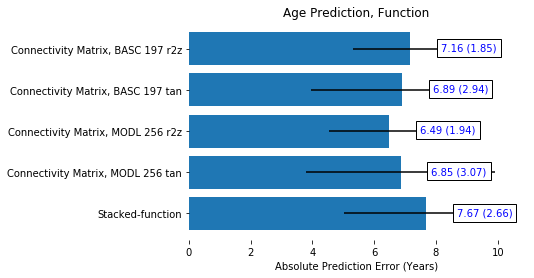

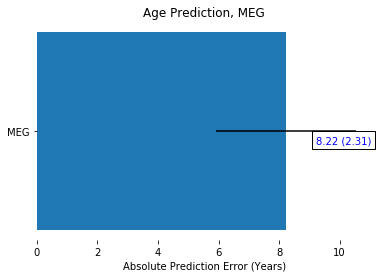

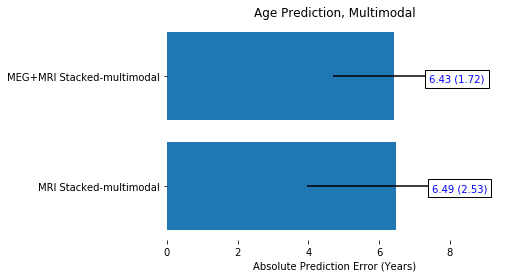

In [23]:
plot_barchart(anatomy_mae_std, title='Age Prediction, Anatomy', bar_text_indent=1)
plot_barchart(function_mae_std, title='Age Prediction, Function', bar_text_indent=1)
plot_barchart(meg_mae_std, title='Age Prediction, MEG', bar_text_indent=1)
plot_barchart(multimodal_mae_std, title='Age Prediction, Multimodal', bar_text_indent=1)

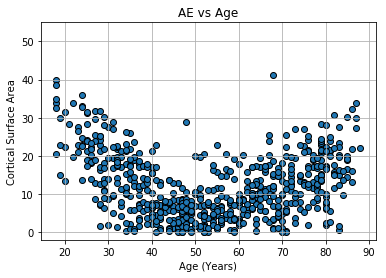

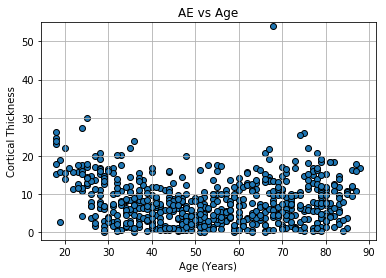

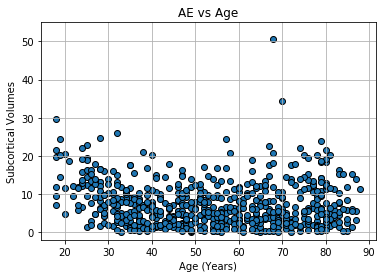

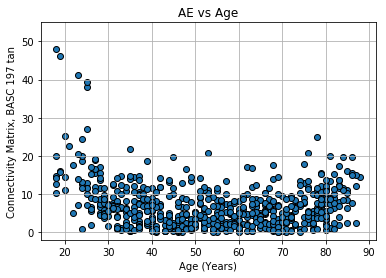

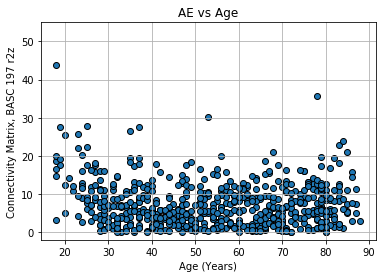

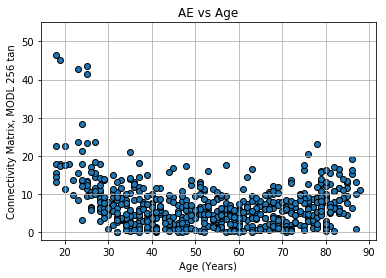

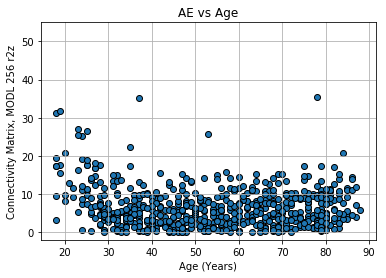

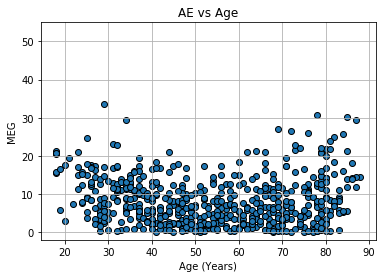

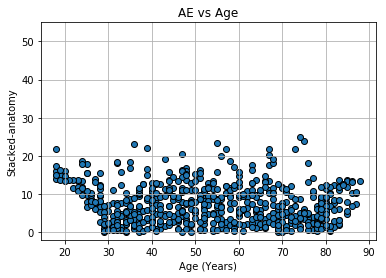

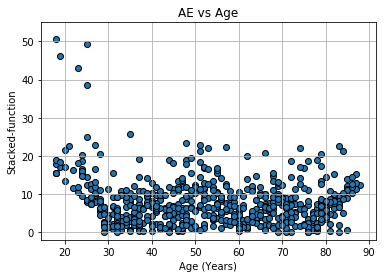

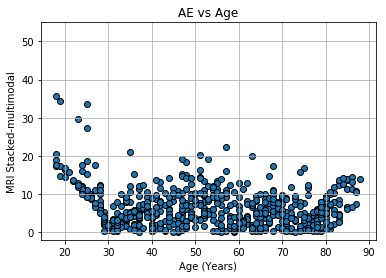

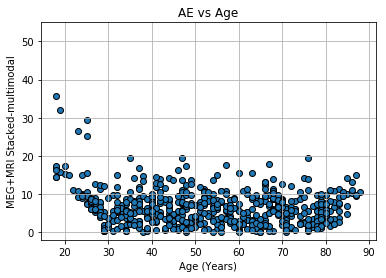

In [24]:
plot_error_age(subjects_predictions, ylim=(-2, 55))

/home/okozynet/miniconda3/envs/mne/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


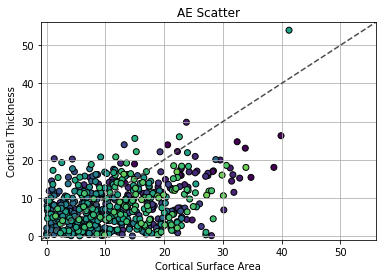

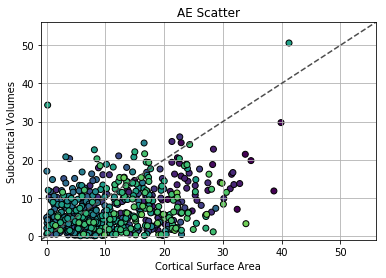

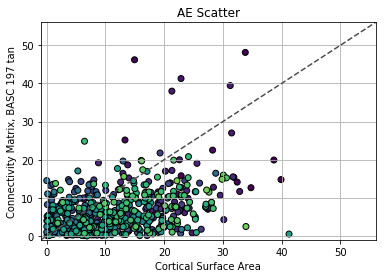

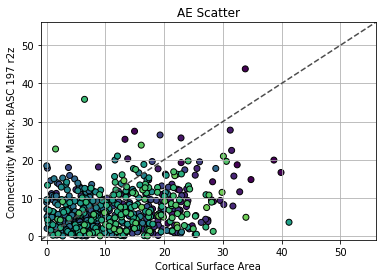

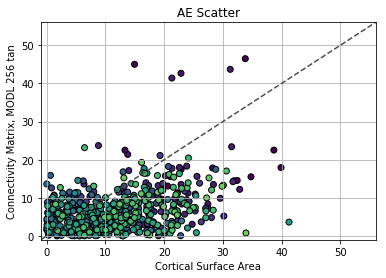

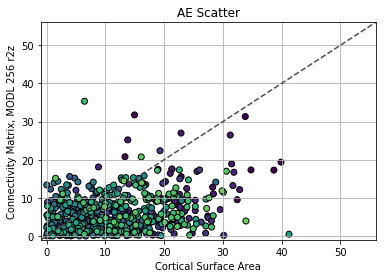

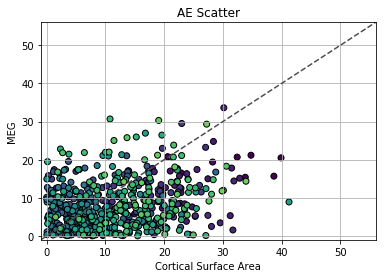

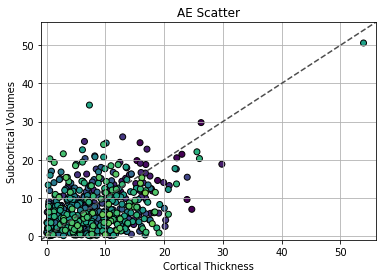

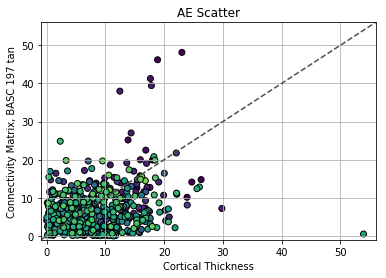

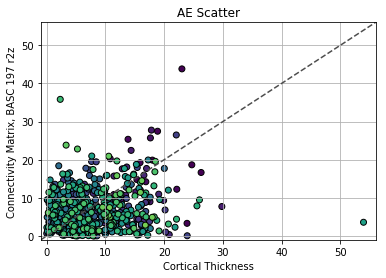

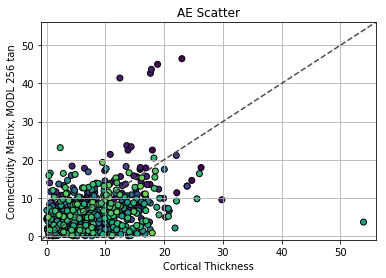

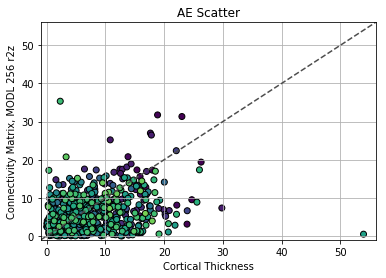

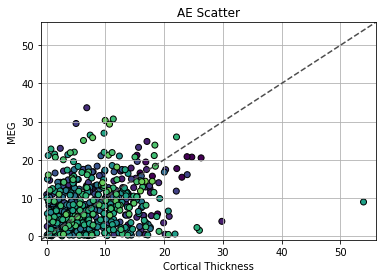

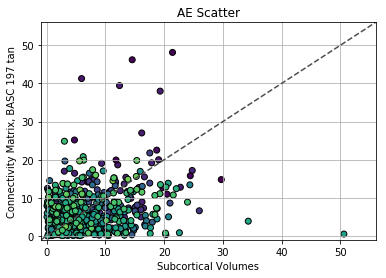

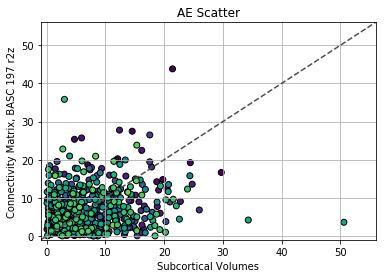

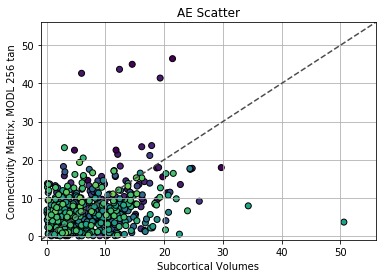

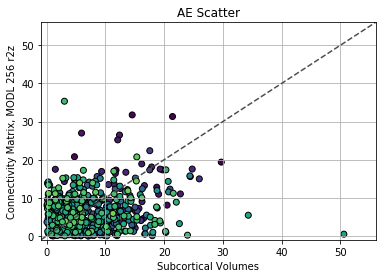

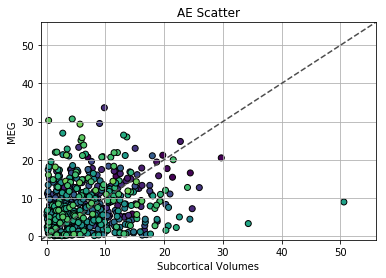

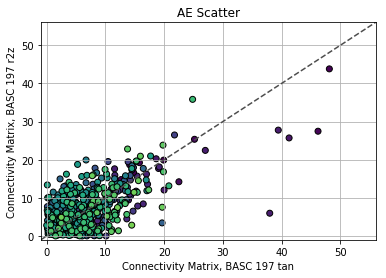

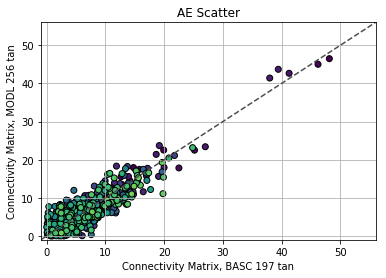

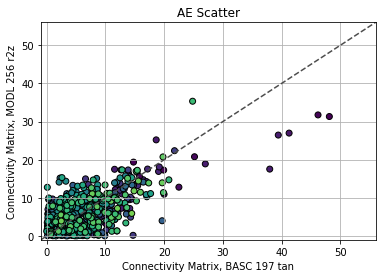

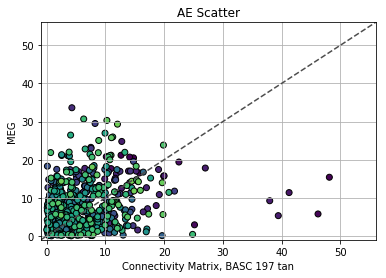

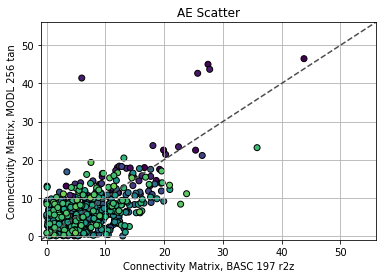

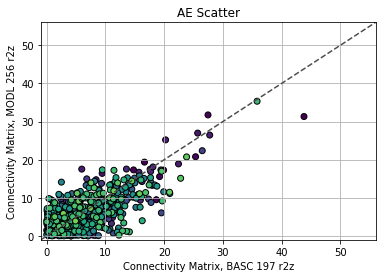

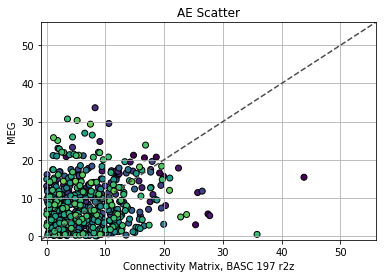

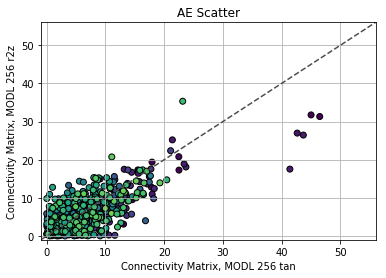

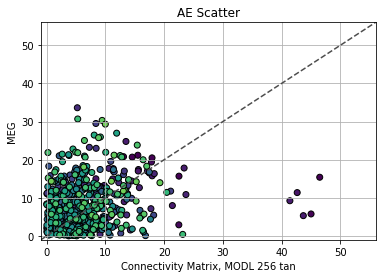

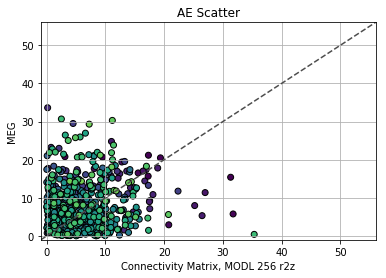

In [25]:
# drop results of stacked predictions
cols2drop = [c for c in subjects_predictions.columns if 'Stack' in c]
plot_error_scatters(subjects_predictions.drop(cols2drop, axis=1), xlim=(0, 55), ylim=(0, 55))

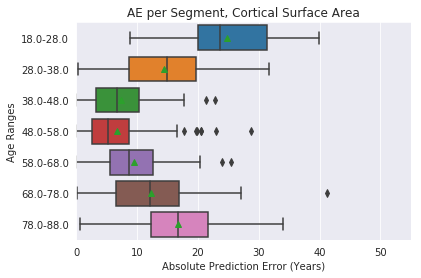

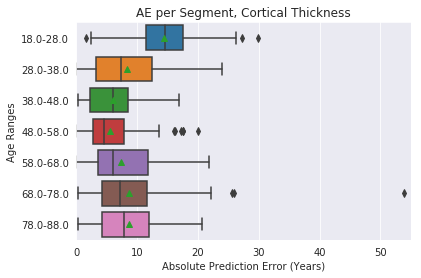

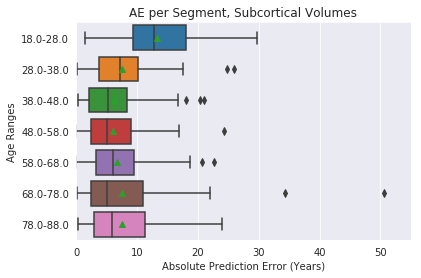

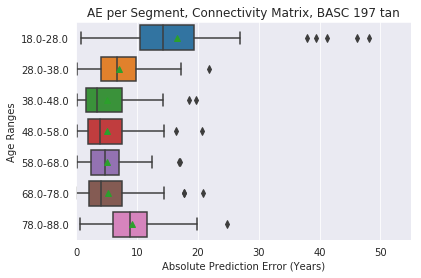

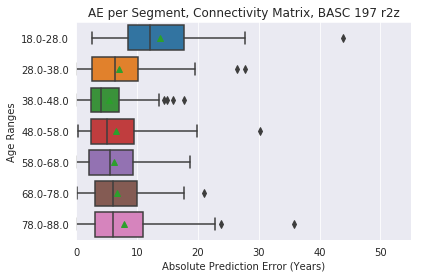

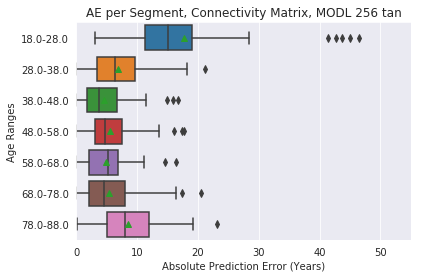

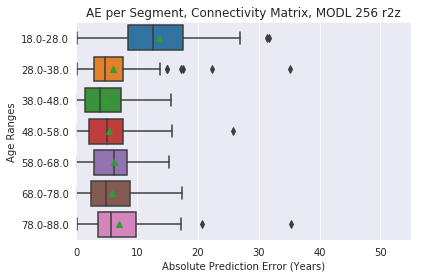

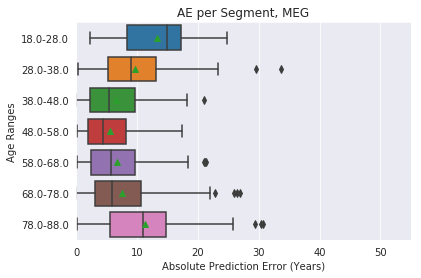

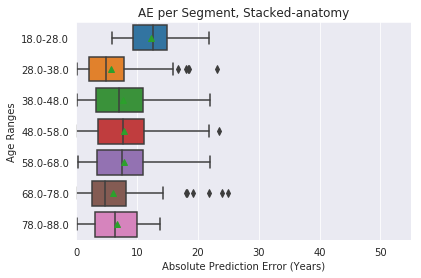

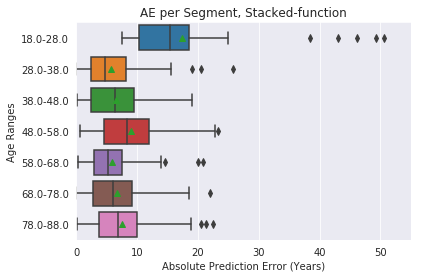

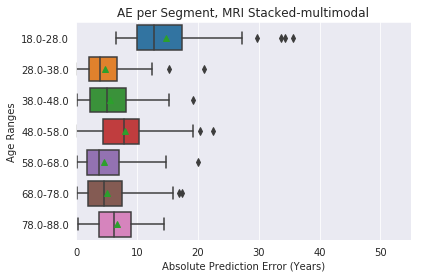

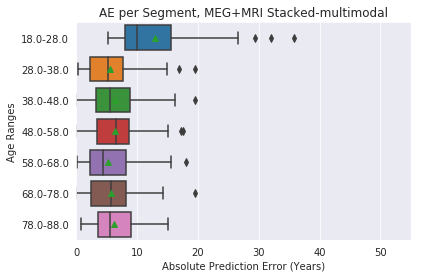

In [26]:
plot_error_segments(subjects_predictions, segment_len=10)

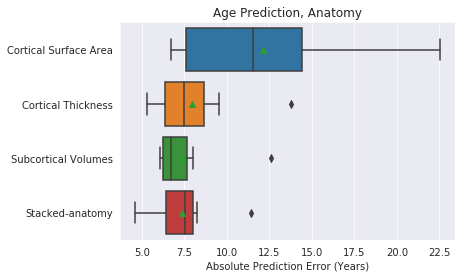

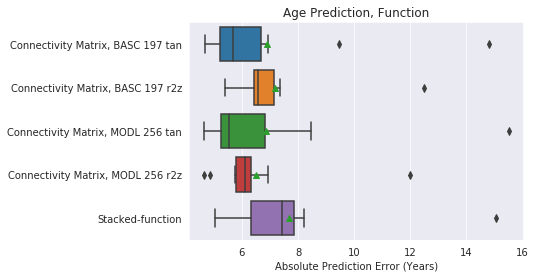

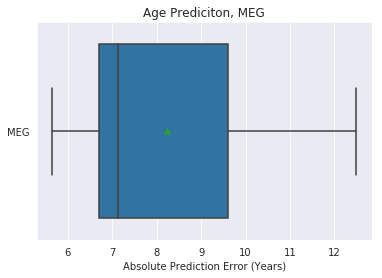

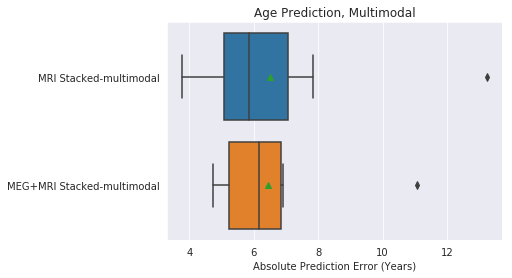

In [27]:
plot_boxplot(anatomy_mae, title='Age Prediction, Anatomy')
plot_boxplot(function_mae, title='Age Prediction, Function')
plot_boxplot(meg_mae, title='Age Prediciton, MEG')
plot_boxplot(multimodal_mae, title='Age Prediction, Multimodal')

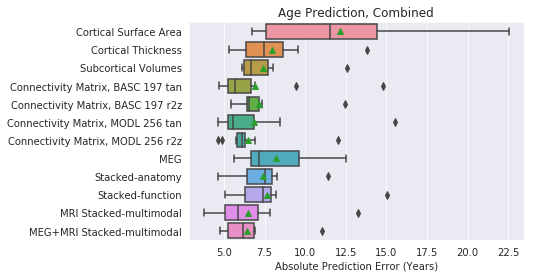

In [28]:
from collections import OrderedDict
from itertools import chain

it_chain = chain(anatomy_mae.items(), function_mae.items(), multimodal_mae.items(), meg_mae.items())

all_mae = OrderedDict((key, value) for key, value in it_chain if 'Stacked' not in key)

all_mae['Stacked-anatomy'] = anatomy_mae['Stacked-anatomy']
all_mae['Stacked-function'] = function_mae['Stacked-function']
all_mae['MRI Stacked-multimodal'] = multimodal_mae['MRI Stacked-multimodal']
all_mae['MEG+MRI Stacked-multimodal'] = multimodal_mae['MEG+MRI Stacked-multimodal']

plot_boxplot(all_mae, title='Age Prediction, Combined')

In [29]:
# dill.dump_session('../../data/ridgecv_azzaro.db')
# dill.load_session('../../data/ridgecv_azzaro.db')